In [1]:
import numpy as np
import pandas as pd

from tqdm.notebook import tqdm
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.ensemble import RandomForestRegressor, RandomForestClassifier
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.datasets import fetch_california_housing
from sklearn.metrics import accuracy_score
from sklearn.metrics import mean_squared_error as mse
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import RandomizedSearchCV
from sklearn.model_selection import train_test_split
from sklearn.utils import shuffle

sns.set(font_scale=1.8, palette='Set2')

##  Сравнение градиентного бустинга и случайного леса

### 1 Задача регрессии

Исследуем зависимость качества предсказаний градиентного бустинга и случайного леса в зависимости от числа базовых моделей на примере задаче регрессии. Для случайного леса будем использовать класс `RandomForestRegressor` библиотеки `sklearn`.

In [38]:
housing = fetch_california_housing()
X, y = housing.data, housing.target

Разобьём данные на обучающую выборку и на валидацию, выделив на валидацию 25% данных.

In [39]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25)

In [4]:
def plot_compare_estimators(estimator_labels, param_grid, train_metrics,
                            test_metrics, param_label='', metrics_label='', 
                            title=''):
    '''Функция для построения графиков зависимости целевой метрики 
    от некоторого параметра модели на обучающей и на валидационной 
    выборке.
    
    :param estimator_labels: массив названий моделей
    :param param_grid: значения исследуемого параметра
    :param train_metrics: массив, где i-ый элемент - 
        это массив значений метрики на обучающей выборке для i-ой модели
    :param test_metrics: массив, где i-ый элемент - 
        это массив значений метрики на валидационной выборке для i-ой модели
    :param param_label: названия параметра
    :param metrics_label: название метрики
    :param title: заголовок для графика
    '''
    
    plt.figure(figsize=(12, 6))
    
    for estimator_id in range(len(estimator_labels)):
        label = estimator_labels[estimator_id]
        plt.plot(
            param_grid, train_metrics[estimator_id], 
            label=f'{label} train', linewidth=3
        )
        plt.plot(
            param_grid, test_metrics[estimator_id],
            label=f'{label} test', linewidth=3
        )
       
    plt.legend()
    plt.xlabel(param_label)
    plt.ylabel(metrics_label)
    plt.title(title, fontsize=20)

Обучим случайный лес для разного числа деревьев и посчитаем `mse`.

In [5]:
rf_mse_train = []  # метрика на трейне
rf_mse_test = []  # метрика на тесте
n_estimators_grid = range(1, 300, 10)

for n_estimators in tqdm(n_estimators_grid):
    forest = RandomForestRegressor(n_estimators= n_estimators)
    forest.fit(X_train, y_train)
    rf_mse_test.append(mse(y_test, forest.predict(X_test)))
    rf_mse_train.append(mse(y_train, forest.predict(X_train)))

  0%|          | 0/30 [00:00<?, ?it/s]

Обучим градиентный бустинг для разного числа деревьев и посчитаем `mse`.

In [6]:
boosting_mse_train = []
boosting_mse_test = []

for n_estimators in tqdm(n_estimators_grid):
    boosting = GradientBoostingRegressor(n_estimators = n_estimators)
    boosting.fit(X_train, y_train)
    boosting_mse_test.append(mse(y_test, boosting.predict(X_test)))
    boosting_mse_train.append(mse(y_train, boosting.predict(X_train)))

  0%|          | 0/30 [00:00<?, ?it/s]

Построим график зависимости `mse` от количества базовых моделей.

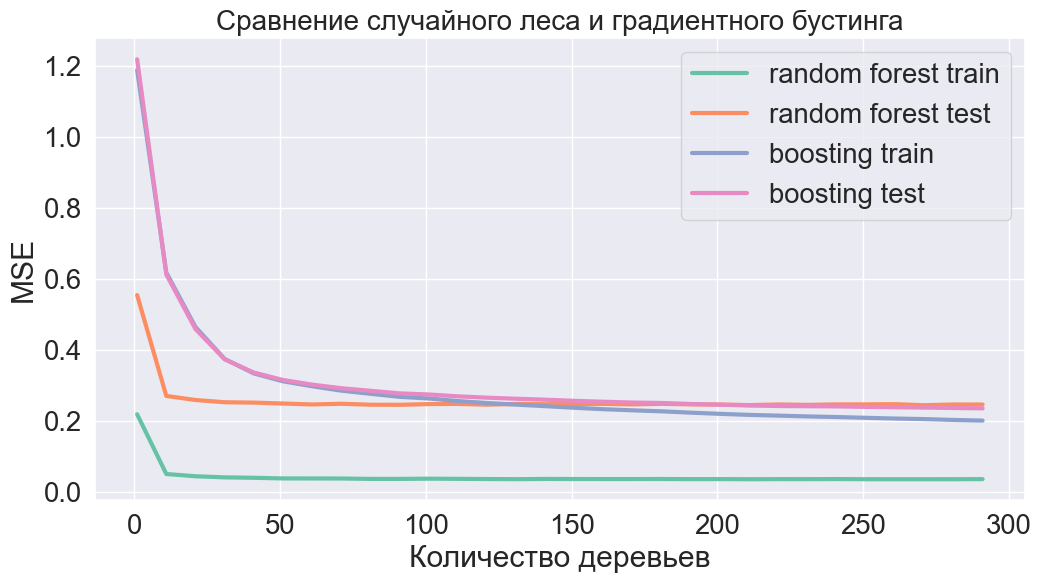

In [7]:
plot_compare_estimators(
    ['random forest', 'boosting'], n_estimators_grid, 
    [rf_mse_train, boosting_mse_train], 
    [rf_mse_test, boosting_mse_test],
    'Количество деревьев', 'MSE', 
    'Сравнение случайного леса и градиентного бустинга'
)

**Вывод.**

лес и бустинги показывают приблизительно одинаковую точность на тесте при больших значениях количества деревьев. Но на малых количествах деревьев лес показывает лучше результат.

Переобучение бустинга при большом количестве деревьев не наблюдается(в нашем случае)

Сравним времена обучения и предсказания случайного леса и градиентного бустинга с параметрами по умолчанию: 

In [40]:
regressor_boosting = GradientBoostingRegressor()

In [41]:
%%timeit
regressor_boosting.fit(X_train, y_train)

2.88 s ± 25.7 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [42]:
%%timeit
regressor_boosting.predict(X_test)

7.99 ms ± 44.7 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)


In [43]:
regressor_forest = RandomForestRegressor(n_jobs=-1)

In [44]:
%%timeit
regressor_forest.fit(X_train, y_train)

1.96 s ± 33.3 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [45]:
%%timeit
regressor_forest.predict(X_test)

32.5 ms ± 305 µs per loop (mean ± std. dev. of 7 runs, 10 loops each)


**Вывод:** 

Бустинг обучается быстрее леса(особенно если его не парралелить). Это может быть связано, что для него используются неглубокие деревья

### 2 Задача классификации

Сделаем аналогичный эксперимент с датасетом для классификации рукописных цифр.

In [20]:
letters_df = pd.read_csv('letter-recognition.data', header=None)
print('shape:', letters_df.shape)
letters_df.head()

shape: (20000, 17)


,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16
0,T,2,8,3,5,1,8,13,0,6,6,10,8,0,8,0,8
1,I,5,12,3,7,2,10,5,5,4,13,3,9,2,8,4,10
2,D,4,11,6,8,6,10,6,2,6,10,3,7,3,7,3,9
3,N,7,11,6,6,3,5,9,4,6,4,4,10,6,10,2,8
4,G,2,1,3,1,1,8,6,6,6,6,5,9,1,7,5,10


In [21]:
print('shape:', letters_df.shape)
letters_df.head()

shape: (20000, 17)


,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16
0,T,2,8,3,5,1,8,13,0,6,6,10,8,0,8,0,8
1,I,5,12,3,7,2,10,5,5,4,13,3,9,2,8,4,10
2,D,4,11,6,8,6,10,6,2,6,10,3,7,3,7,3,9
3,N,7,11,6,6,3,5,9,4,6,4,4,10,6,10,2,8
4,G,2,1,3,1,1,8,6,6,6,6,5,9,1,7,5,10


In [22]:
X = letters_df.values[:, 1:]
y = letters_df.values[:, 0]

Разобьём данные на обучающую и тестовую выборки.

In [23]:
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42)

Обучим случайный лес для разного числа деревьев и посчитаем метрику `accuracy`.

In [25]:
rf_accuracy_train = []
rf_accuracy_test = []
n_estimators_grid = range(1, 300, 25)

for n_estimators in tqdm(n_estimators_grid):
    forest = RandomForestClassifier(n_estimators= n_estimators)
    forest.fit(X_train, y_train)
    rf_accuracy_test.append(accuracy_score(y_test, forest.predict(X_test)))
    rf_accuracy_train.append(accuracy_score(y_train, forest.predict(X_train)))

  0%|          | 0/12 [00:00<?, ?it/s]

Обучим градиентный бустинг для разного числа деревьев и посчитаем метрику `accuracy`.

In [28]:
boosting_accuracy_train = []
boosting_accuracy_test = []
n_estimators_grid = range(1, 300, 25)

for n_estimators in tqdm(n_estimators_grid):
    boosting = GradientBoostingClassifier(n_estimators = n_estimators)
    boosting.fit(X_train, y_train)
    boosting_accuracy_test.append(accuracy_score(y_test, boosting.predict(X_test)))
    boosting_accuracy_train.append(accuracy_score(y_train, boosting.predict(X_train)))

  0%|          | 0/12 [00:00<?, ?it/s]

Построим график зависимости `accuracy` от количества базовых моделей.

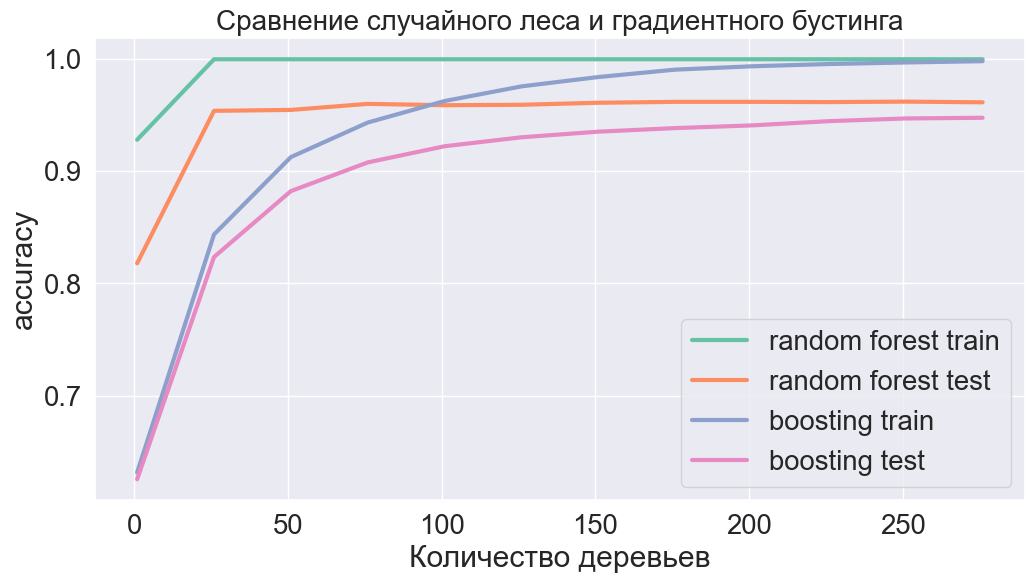

In [29]:
plot_compare_estimators(
    ['random forest', 'boosting'], n_estimators_grid, 
    [rf_accuracy_train, boosting_accuracy_train],
    [rf_accuracy_test, boosting_accuracy_test],
    'Количество деревьев', 'accuracy', 
    'Сравнение случайного леса и градиентного бустинга'
)

**Вывод.**

бустинг показывает резутат хуже, чем лес. Если бы подбирали гиперпараметры, бустинг показывал бы лучшие результаты, тем более если взять не стандартный, а Cat, например